# Simple Demo: Step Function
This example is taken (with a bit of adaption) from [here](https://github.com/ICL-SML/Doubly-Stochastic-DGP/blob/master/demos/demo_1D_regression.ipynb). The example illustrate a deepGP fit for a step function. Normal GPs with stationary kernels usually fail at this task. We start with some imports.

In [1]:
# useful imports
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

/home/aboustati/miniconda3/envs/gpflow-v1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# dgplib imports
from dgplib.layers import InputLayer, OutputLayer, HiddenLayer
from dgplib.models import Sequential

from dgplib import DSDGP

In [3]:
# gpflow imports
import gpflow

from gpflow.kernels import RBF, White, Matern52
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import Linear

## Data
We start of by generating the training and test data:

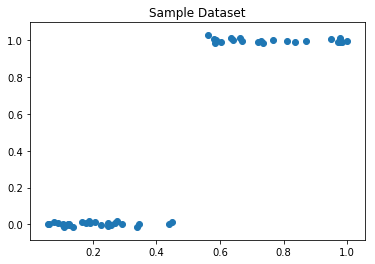

In [4]:
Ns = 300
Xs = np.linspace(-0.5, 1.5, Ns)[:, None]

N, M = 50, 25
X = np.random.uniform(0, 1, N)[:, None]
Z = np.random.uniform(0, 1, M)[:, None]
f_step = lambda x: 0. if x<0.5 else 1.
Y = np.reshape([f_step(x) for x in X], X.shape) + np.random.randn(*X.shape)*1e-2

def plot_data(X, Y):
    plt.title('Sample Dataset')
    plt.scatter(X, Y)
    plt.show()
    
plot_data(X, Y)

## Model Construction
We move on to constructing the model. First we initialize the layers. In this example we are using a 2-layer DGP, an input layer and an output layer.

In [5]:
# Layers
input_layer = InputLayer(input_dim=1,
                         output_dim=1, 
                         num_inducing=M, 
                         kernel=RBF(1, lengthscales=0.2, variance=1.)+White(1, variance=1e-5), 
                         mean_function=Linear())

input_layer.q_sqrt = input_layer.q_sqrt.value * 1e-5

output_layer = OutputLayer(input_dim=1, 
                           output_dim=1, 
                           num_inducing=M,
                           kernel=RBF(1, lengthscales=0.2, variance=1.)+White(1, variance=1e-5))

Next, we wrap the layers around a `Sequential` object. This takes care of initializing the inducing inputs when fed into the model.

In [6]:
seq = Sequential([input_layer, output_layer])

Finally, we create and compile a model object.

In [7]:
model = DSDGP(X=X, Y=Y, Z=Z, layers=seq, likelihood=Gaussian())

Model Parameters Initialized


In [8]:
print(model)

                                                       class prior transform  \
DSDGP/layers/layers/item0/Z                        Parameter  None    (none)   
DSDGP/layers/layers/item0/kernel/rbf/variance      Parameter  None       +ve   
DSDGP/layers/layers/item0/kernel/rbf/lengthscales  Parameter  None       +ve   
DSDGP/layers/layers/item0/kernel/white/variance    Parameter  None       +ve   
DSDGP/layers/layers/item0/mean_function/A          Parameter  None    (none)   
DSDGP/layers/layers/item0/mean_function/b          Parameter  None    (none)   
DSDGP/layers/layers/item0/q_mu                     Parameter  None    (none)   
DSDGP/layers/layers/item0/q_sqrt                   Parameter  None    (none)   
DSDGP/layers/layers/item1/Z                        Parameter  None    (none)   
DSDGP/layers/layers/item1/kernel/rbf/variance      Parameter  None       +ve   
DSDGP/layers/layers/item1/kernel/rbf/lengthscales  Parameter  None       +ve   
DSDGP/layers/layers/item1/kernel/white/v

/home/aboustati/Documents/PhD/Software/gpflow1.0/GPflow/gpflow/misc.py:30: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  df = df.reindex_axis(keys, axis=1)


In [9]:
model.compile()

## Training
We train the model by maximising the variational lower bound on the log marginal likelihood. We use the Adam optimiser packaged with `GPflow` for this task.

In [10]:
model.compute_log_likelihood()

-357.2383839789025

In [11]:
opt = gpflow.train.AdamOptimizer(0.01)
opt.minimize(model, maxiter=1000)

In [12]:
model.compute_log_likelihood()

67.72492248545562

We can see that the bound on log marginal likelihood has increased.

## Testing
We now test our model.

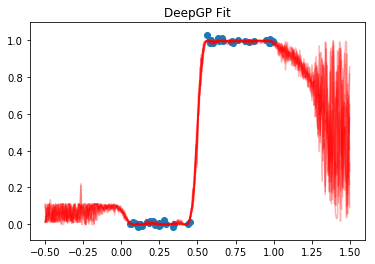

In [13]:
for _ in range(10):
    mu, sigma = model.predict_f(Xs, 1)
    plt.plot(Xs, mu.reshape(Xs.shape), color='r', alpha=0.3)
    
plt.title('DeepGP Fit')
plt.scatter(X, Y);